### This notebook is for illustrating lick sensor data upon slow and binge eating.
#### tasks:
#### - [x] Load phenosys csv files, convert date time to seconds
#### - [x] Load lick sensor activation time, adding missing values
#### - [ ] perform cleaning (removed motor caused activation)
#### - [ ] Calculate licks and separate them into slow and binge eating bouts

In [1]:
## import functions

import sys
sys.path.append('/Users/hunglo/Documents/python_codes/')
from IO_ import load_csv_files


In [2]:
## import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pynapple as nap
from os import listdir
from os.path import isfile, join

%matplotlib inline
%config InlineBackend.figure_format = 'svg' ## disable for now, too bulky for all the individual plots
# %config InlineBackend.figure_format = 'retina'

## create color map
my_color_map = ['#56b4e9',
                '#e69f00',
                '#009e73',
                '#f0e442',
                '#0072b2',
                '#d55e00',
                '#cc79a7']

## font setting
plt.rcParams["font.family"] = 'Arial'
plt.rcParams.update({'font.size': 8})

my_color_map = sns.color_palette(my_color_map)

# def get_auto_colors(n_mice):
#     auto_color_map_cat = sns.color_palette("husl", n_mice)
#     return auto_color_map_cat


In [89]:
## functions

def load_id(file_path):
    mouse_id = file_path.split('_opto_')[0].split('/')[-1]
    print(mouse_id)
    date = file_path.split('_Inscopix-')[1].split('_')[0]
    date = date.replace('.','')
    print(date)

    return mouse_id, date
    
def load_data(file_path):

    L1_timestamps, L2_timestamps, all_lick_events = load_csv_files.lick_event_calculate(csv_path=file_path)
    P1_time, P1C_time, P2_time, P2A_time, pump_all = load_csv_files.GPIO_event_calculate(csv_path=file_path)
    L1_timestamps,L2_timestamps,P1_time, P1C_time, P2_time, P2A_time = load_csv_files.remove_exceeding_timepoint(L1_timestamps,L2_timestamps,P1_time, P1C_time, P2_time, P2A_time,time=3600)
    L1_timestamps = load_csv_files.select_lick_sensor(L1_timestamps, L2_timestamps)
    Pump1, Pump2 = load_csv_files.select_opto_pump_led(P1_time, P1C_time, P2_time, P2A_time)
    # if len(Pump2) == 0:
    #     Pump2 
    Pump1_new,Pump2_new,Pump_all_no_init = load_csv_files.remove_pheno_init_opto(Pump1,Pump2)

    L1_timestamps_new = load_csv_files.add_missing_licks(Pump1_new,L1_timestamps) ## notice I used Pump1_new, not Pump_all_no_init, since Pump2 data is not actually related to lick events

    ## baseline finish time
    baseline_finish_time = load_csv_files.baseline_finish_time(file_path)

    return L1_timestamps_new,Pump1_new,Pump2_new,baseline_finish_time

def plot_lick_pump_LED_events(L1_timestamps_new,Pump1_new,Pump2_new,baseline_finish_time,draw_baseline = False,draw_interval = False):
    ## Viz pump & lick sensor data
    fig,axes = plt.subplots(figsize=[13,3.5],nrows=2,sharex=True,gridspec_kw={'height_ratios': [1, 2]})

    axes[1].eventplot([L1_timestamps_new,Pump1_new,Pump2_new],colors=['C3','C1','C0'],linelengths=0.8,linewidths=1)
    axes[1].legend([f'Licks n={len(L1_timestamps_new)}',f'Milk pump n={len(Pump1_new)}',f'LED n={len(Pump2_new)}'],loc=1,fontsize=8,frameon=False)

    licks = nap.Ts(L1_timestamps_new,time_units='s')
    axes[0].plot(licks.count(1))
    a = licks.count(1).values
    a_nozero = a[a != 0]
    axes[0].text(x=150,y=np.max(licks.count(1)),s=f'max={np.max(licks.count(1))}\nmedian={int(np.median(a_nozero))}',ha='center',va='center')

    axes[0].set_ylabel('lick rate (Hz)')
    axes[1].set_yticks([])
    axes[1].set_ylabel('time stamps')
    axes[1].set_xlabel('time (seconds)')

    axes[1].axvspan(xmin=0,xmax=300,alpha=0.2,color='C0')
    axes[1].axvspan(xmin=300,xmax=baseline_finish_time,alpha=0.2,color='C1')
    axes[1].text(x=150,y=2.5,s='Pump\ninactivated',va='top',ha='center')

    axes[0].set_title(f'Opto protocol: {LED_state}\n{mouse_id}_{date}')
    axes[1].axvline(x=baseline_finish_time,color='k',ls=':')
    axes[1].text(x=baseline_finish_time+10,y=2.75,s=f'{int(round(baseline_finish_time-300))} sec',va='bottom',ha='left')
    plt.xlim(xmin=-5)
    sns.despine()

    draw_baseline = False # change to True if you want to add arrows
    if draw_baseline:
        # axes[1].arrow(x=300+30,y=2.7,dx=-20,dy=0,head_width=0.15, head_length=5, fc='C0', ec='C0')
        # axes[1].arrow(x=baseline_finish_time-30,y=2.7,dx=20,dy=0,head_width=0.15, head_length=5, fc='C0', ec='C0')
        axes[1].plot([300,baseline_finish_time],[2.7,2.7])

    draw_interval = False
    if draw_interval:
        LED_intervals = Pump2_new[1:]-Pump2_new[:-1]
        for idx, inter_ in enumerate(LED_intervals):
            axes[1].text(x=Pump2_new[idx]+inter_/2,y=2.3,s=f'{int(round(inter_,))}',ha='center',va='center')
            # axes[1].plot([Pump2_new[idx],Pump2_new[idx+1]],[2.4,2.4],ls=':')
            axes[1].arrow(x=Pump2_new[idx]+10+5+2,y=2.3,dx=-10,dy=0,head_width=0.15, head_length=5, fc='C0', ec='C0')
            axes[1].arrow(x=Pump2_new[idx+1]-10-5-2,y=2.3,dx=10,dy=0,head_width=0.15, head_length=5, fc='C0', ec='C0')
        
    plt.tight_layout()

def plot_feeding_bout(Pump1_new,Pump2_new,feeding_epoch,df,mouse_id,date,LED_state):

    plt.figure(figsize=[13,3.5])
    plt.eventplot(Pump2_new,lineoffsets=2,linelengths=0.8,color='C0',label='LED')
    plt.eventplot(Pump1_new,linelengths=0.8,colors='C1',label='Milk pump')
    for i in range(df.shape[0]):
        if i ==0:
            plt.plot([df['LED'][i],df['binge_end'][i]],[2.5,2.5],color=my_color_map[i%7],label='Feeding duration since LED')
        else:
            plt.plot([df['LED'][i],df['binge_end'][i]],[2.5,2.5],color=my_color_map[i%7])
    for i in range(df.shape[0]):
        if i ==0:
            plt.plot(df['binge_end'][i],1.5,marker='.',color=my_color_map[i%7],ls='',label='Bout end after LED on')
        else:
            plt.plot(df['binge_end'][i],1.5,marker='.',color=my_color_map[i%7],ls='')

    for i in range(feeding_epoch.shape[0]):
        if i == 0:
            plt.plot([feeding_epoch['start'][i],feeding_epoch['end'][i]],[0.5,0.5],color=my_color_map[i%7],label=f'Feeding bout (gap <{interval}s)',lw=3)
        else:       
            plt.plot([feeding_epoch['start'][i],feeding_epoch['end'][i]],[0.5,0.5],color=my_color_map[i%7],lw=3)
    # plt.legend(['LED','Milk Pump','Binge biouts'])
    plt.legend(loc=1,frameon=False,fontsize=8)
    plt.ylim(ymax=4)
    plt.title(f'{mouse_id}_{date}_{LED_state}')
    plt.xlim(xmin=-5)
    sns.despine()
    plt.tight_layout()

# def detect_feeding_bout(Pump1,interval=3):
#     # if pump interval is less than 2 seconds?
#     Pump1 = np.pad(Pump1, (1, 0), 'constant', constant_values=(0,0))
#     diff = Pump1[1:]-Pump1[:-1]
#     gap = diff>interval # binary data
#     idx = np.where(gap == 1) # idx == 1
#     start_concat, end_concat = [],[]
#     for idx_ in idx:
#         start_concat.append(Pump1[idx_+1])
#         end_concat.append(Pump1[idx_])
#     start_concat = start_concat[0][:-1] # remove empty starting
#     end_concat = end_concat[0][1:] # remove empty ending
#     ## check if it's too short? should we add this?
    
#     return start_concat, end_concat

# def detect_feeding_bout(Pump1,interval=3):
#     Pump1 = np.pad(Pump1, (1, 1), 'constant', constant_values=(0,Pump1.max()+interval*10)) # so the last value is more than interval
#     diff = Pump1[1:]-Pump1[:-1]
#     gap = diff>interval # binary data
#     idx = np.where(gap == 1) # idx == 1
#     start_concat, end_concat = [],[]
#     for idx_ in idx:
#         start_concat.append(Pump1[1:][idx_])
#         end_concat.append(Pump1[:][idx_])
#     start_concat = start_concat[0][:-1] # remove empty starting
#     end_concat = end_concat[0][1:] # remove empty ending

#     # binge_epoch = nap.IntervalSet(start_concat,end_concat)

#     # ## run through the rows to make sure there isn't no duration epochs
#     # ## note this should be taken care of from the pynapple package but somehow it isn't working properly 
#     # binge_epoch_clean = pd.DataFrame(data=[], columns=['start','end'])
#     # for n in range(binge_epoch.shape[0]):
#     #     for x,y in binge_epoch[n:n+1].values:
#     #         # print(x,y)
#     #         # if x!= y: ## this is the old alg
#     #         # if y-x >interval:
#     #         if True:
#     #             binge_epoch_clean = pd.concat([binge_epoch_clean,binge_epoch[n:n+1]])
#     # binge_epoch_clean = nap.IntervalSet(binge_epoch_clean['start'],binge_epoch_clean['end'], time_units='s')
#     return start_concat, end_concat

## burst detection function from other ppl, adapted from the following link
## https://spikesandbursts.wordpress.com/2023/08/24/patch-clamp-data-analysis-in-python-bursts/
def burst_detection(df, spike_times,
                    n_spikes, 
                    max_isi, 
                    # min_duration,  # Optional
                    min_ibi):
     
    """
    Detects bursts in spike data based on spike times, 
    by identifying consecutive spikes that fulfill the criteria of:
    minimum number of spikes, maximum interspike interval, and minimum interburst interval.
     
    Arguments: 
        df: DataFrame with spike data.
        spike_times: Column name for spike positions.
        spike_amplitudes: Column name for spike amplitudes.
        spike_peaks: Column name for spike peak amplitudes. 
        n_spikes: Minimum number of spikes within a burst.
        max_isi: Max interspike interval within the burst.
        min_duration: Minimum burst duration.
        min_ibi: Minimum interburst interval (optional).
         
    Returns:
        DataFrame with burst information.
    """
     
    df = df.sort_values(by=spike_times)  # Sort DataFrame by spike positions
    df['burst'] = np.nan  # Create column for burst labels
    burst_num = 0        # Initialize burst number
    burst_start = None   # Initialize burst start position
    last_spike = None    # Initialize last spike position
 
    for i, row in df.iterrows():  # Loop through DataFrame rows 
        spike = row[spike_times]   # Extract the spike position 
         
        if burst_start is None:   # It checks if it is the first spike 
            burst_start = spike   # It marks the current spike position as the start of a burst
            last_spike = spike    # Update the last_spike position to the current spike position
            df.at[i, 'burst'] = burst_num   # Assign burst number
        elif spike - last_spike <= max_isi:  # It checks if the current spike is within max isi
            df.at[i, 'burst'] = burst_num  
            last_spike = spike 
        elif spike - last_spike > min_ibi:  # It checks if the interburst interval has been reached
            burst_num += 1 
            burst_start = spike 
            last_spike = spike  
            df.at[i, 'burst'] = burst_num
     
    # Filter bursts with less than min_spikes
    df = df[df.groupby('burst')[spike_times].transform('count') >= n_spikes]
     
    # Filter burst shorter that min_duration (min_duration parameter)
    # df = df[df.groupby('burst')[spike_times].transform('max') 
    #         - df.groupby('burst')[spike_times].transform('min')
    #         >= min_duration]
     
    # Calculate burst information by aggregating single spike information
    bursts = df.groupby('burst')[spike_times].agg(['min', 'max', 'count'])
    bursts.columns = ['burst_start', 'burst_end', 'spikes_in_bursts']
    bursts['burst_length'] = bursts['burst_end'] - bursts['burst_start']
    # bursts['avg_spike_amplitude'] = df.groupby('burst')[spike_amplitudes].mean()
    # bursts['avg_spike_peaks'] = df.groupby('burst')[spike_peaks].mean()  
    bursts['spikes_frequency'] = bursts['spikes_in_bursts'] / bursts['burst_length']
    bursts = bursts.reset_index()
    bursts['burst_number'] = bursts.index + 1
     
    return bursts[['burst_number', 'burst_start', 'burst_end', 
                   'burst_length', 'spikes_in_bursts', 'spikes_frequency']]

## new detection function that used the above function
def detect_binge_bout(Pump_event, n_pumps, max_isi, min_ibi):
    df = pd.DataFrame(Pump_event,columns=['spike_times'])
    binge_df = burst_detection(df=df,spike_times='spike_times', 
                             n_spikes = n_pumps,  
                             max_isi = max_isi,
                             min_ibi = min_ibi)
    binge_df = binge_df.rename(columns={"burst_number":"binge_bout_idx",
                                    "burst_start":"start",
                                    "burst_end":"end",
                                    "burst_length":"bout_duration",
                                    "spikes_in_bursts":"deliveries_in_bout",
                                    "spikes_frequency":"delivery_frequency"})
    
    return binge_df, nap.IntervalSet(start= binge_df['start'],end=binge_df['end'])

def duration_after_LED(binge_epoch,Pump2_new):
    binge_start_list = []
    binge_end_list = []
    duration_list = []
    for time in Pump2_new:
        idx = binge_epoch['start'][binge_epoch['start']<time].index[-1] # find the last binge bout start before LED
        start_ = binge_epoch['start'][binge_epoch['start']<time].iloc[-1]
        ## get the binge end with the idx
        end_ = binge_epoch['end'][binge_epoch['start']<time].iloc[idx]

        if end_ > time: # if the binge bout stops after LED
            duration = end_ - time
            binge_start_list.append(start_)
            binge_end_list.append(end_)
            duration_list.append(duration)
        else:
            duration = 0 # assume mouse stopped right when the LED is triggered so the binge bout stopped before LED
            binge_start_list.append(start_)
            binge_end_list.append(end_)
            duration_list.append(duration)
        df = pd.DataFrame([Pump2_new,binge_start_list,binge_end_list,duration_list]).T
        df = df.rename(columns={0 : "LED",1:'binge_start',2:'binge_end',3:'duration'})
        df_2 = df.dropna()
        df_3 = df_2.drop_duplicates(subset="binge_end", keep='first')
        df_3.reset_index(inplace=True,drop=True)
    return df_3

def licks_after_LED(binge_epoch,L1_timestamps_new,Pump2_new,window=4):
    binge_start_list = []
    binge_end_list = []
    duration_list = []
    licks_list = []
    for time in Pump2_new:
        idx = binge_epoch['start'][binge_epoch['start']<time].index[-1] # find the last binge bout start before LED
        start_ = binge_epoch['start'][binge_epoch['start']<time].iloc[-1]
        ## get the binge end with the idx
        end_ = binge_epoch['end'][binge_epoch['start']<time].iloc[idx]

        if end_ > time: # if the binge bout stops after LED
            duration = end_ - time
            binge_start_list.append(start_)
            binge_end_list.append(end_)
            duration_list.append(duration)
            licks = L1_timestamps_new[L1_timestamps_new>time]
            licks = licks[licks<time+window]
            licks_list.append(len(licks))

        else:
            duration = 0 # assume mouse stopped right when the LED is triggered so the binge bout stopped before LED
            binge_start_list.append(start_)
            binge_end_list.append(end_)
            licks = L1_timestamps_new[L1_timestamps_new>time]
            licks = licks[licks<time+window]
            licks_list.append(len(licks))
            duration_list.append(duration)
        df = pd.DataFrame([Pump2_new,binge_start_list,binge_end_list,duration_list,licks_list]).T
        df = df.rename(columns={0 : "LED",1:'binge_start',2:'binge_end',3:'duration',4:'licks_after_LED'})
        df_2 = df.dropna()
        df_3 = df_2.drop_duplicates(subset="binge_end", keep='first')
        df_3.reset_index(inplace=True,drop=True)
    return df_3


def print_stats(feeding_epoch,df,Pump1_new,baseline_finish_time):

    total_feeding_time = (feeding_epoch['end']-feeding_epoch['start']).sum()
    total_post_LED_feeding_time = df['duration'].sum()
    mean_feeding_time = (feeding_epoch['end']-feeding_epoch['start']).mean()
    total_milk_consumption = len(Pump1_new)
    mean_post_LED_feeding_duration = df['duration'].mean()

    print(f'baseline finish time = {round(baseline_finish_time,2)} sec')
    print(f'total feeding time = {round(total_feeding_time,2)} sec')
    print(f'total post LED feeding time = {round(total_post_LED_feeding_time,2)} sec')
    print(f'total milk consumption = {total_milk_consumption} deliveries')
    print(f'# feeding bout = {feeding_epoch.shape[0]}')
    print(f'mean feeding bout duration = {round(mean_feeding_time,2)}')
    print(f'mean post LED feeding duration = {round(mean_post_LED_feeding_duration,2)}')

def return_stats(file_path,LED_on_date_list,interval):
    mouse_id, date = load_id(file_path) 
    L1_timestamps_new,Pump1_new,Pump2_new,baseline_finish_time = load_data(file_path)

    if date in LED_on_date_list:
        LED_state = 'LED on'
    else:
        LED_state = 'LED off'

    print(mouse_id)
    print(date)    
    print(LED_state)
    # feed_start, feed_end = detect_feeding_bout(Pump1_new,interval=interval)
    # binge_df, () = detect_binge_bout()
    _, feeding_epoch = detect_binge_bout(Pump_event=Pump1_new,
                              n_pumps = 3, # min of pump events in one binge bout  
                              max_isi = interval,
                              min_ibi = interval)

    # feeding_epoch = nap.IntervalSet(feed_start,feed_end)
    if len(Pump2_new) == 0: # in case no LED trigger at all
        df = pd.DataFrame(columns=['LED','binge_start','binge_end','duration'],data=np.array([np.nan,np.nan,np.nan,np.nan]).reshape(1,-1))
        df_licks = pd.DataFrame(columns=['LED','binge_start','binge_end','duration','licks_after_LED'],data=np.array([np.nan,np.nan,np.nan,np.nan,0]).reshape(1,5))
    else:
        df = duration_after_LED(feeding_epoch,Pump2_new)
        df_licks = licks_after_LED(feeding_epoch,L1_timestamps_new,Pump2_new,window=4)

    # print_stats(feeding_epoch,df,Pump1_new,baseline_finish_time)
    print('====================================================\n')

    return mouse_id, date, LED_state, L1_timestamps_new, Pump1_new, Pump2_new, feeding_epoch, df, df_licks, baseline_finish_time


def save_plot_pdf(plot_name):
    fig_output_folder = '/Users/hunglo/Documents/inscopix_csv/fig_output/'
    kwargs = {"facecolor":"white","dpi":300,"bbox_inches":"tight"}
    # kwargs = {"facecolor":"white","dpi":300} # no tight arg here, to prevent fontsize changes
    plt.savefig(f'{fig_output_folder}{plot_name}.pdf',**kwargs)

def jitter_points(ax):
    for points in axes[virus_idx].collections:
        vertices = points.get_offsets().data
    if len(vertices) > 0:
        vertices[:, 0] += np.random.uniform(-0.15, 0.15, vertices.shape[0])
        points.set_offsets(vertices)

def make_20hz_5pulse(Pump2_new):
    Pump2_new_20hz = [np.linspace(t,t+5-0.05,100) for t in Pump2_new] # add 20 Hz 5 sec in
    Pump2_new_20hz_flat = []
    for sublist in Pump2_new_20hz:
        for item in sublist:
            Pump2_new_20hz_flat.append(round(item,2)) # round is necessary here since this introduce some tiny jittering in the timepoints (0.000...02) or so
    return Pump2_new_20hz_flat


In [90]:
## All together

## Settings
interval = 4 ## sec, defined for when a feeding bout is discontinued and separated into a different feeding bout
# LED_on_date_list = ['230106','230110','230112','230114','230117','230120','230221','230223','230225','230228','230302','230304']
LED_on_date_list = ['240319','240321','240323','240326','240328','240330'] # for ChR2 batch 1
                    
file_folder = '/Users/hunglo/Documents/inscopix_csv/opto_csv_chr2/csv_folder/' # path where we have all the opto data in csv format
fig_output_folder = '/Users/hunglo/Documents/inscopix_csv/opto_csv_chr2/fig_output/'
file_path_list = [f for f in listdir(file_folder) if isfile(join(file_folder, f))]
file_path_list = sorted([f for f in file_path_list if '_.csv' in f])

show_plot = False

# create empty dict for holding each variables through the for loop
lick_dict = {}
milk_dict = {}
duration_dict = {}
duration_LED_dict = {}
Pump1_dict = {}
baseline_dict = {}
licks_after_LED_dict = {}
feeding_epoch_dict = {}
lick_no_led = []
lick_with_led = []

for idx, file in enumerate(file_path_list[:]):
# if True:
    file_path = join(file_folder,file)
    # file_path = '/Users/hunglo/Downloads/DSC021998_opto_Inscopix-24.03.19_.csv'
    mouse_id, date, LED_state, L1_timestamps_new, Pump1_new, Pump2_new, feeding_epoch, df, df_licks, baseline_finish_time = return_stats(file_path,LED_on_date_list,interval)
    Pump2_new = make_20hz_5pulse(Pump2_new) # only for ChR2 exps, not for eOPN3
    if show_plot:
        plot_lick_pump_LED_events(L1_timestamps_new,Pump1_new,Pump2_new,baseline_finish_time,draw_baseline = False,draw_interval = False)
    lick_dict[f'{mouse_id}_{date}'] = L1_timestamps_new
    milk_dict[f'{mouse_id}_{date}'] = Pump1_new
    total_feeding_time = (feeding_epoch['end']-feeding_epoch['start']).sum()
    duration_dict[f'{mouse_id}_{date}'] = total_feeding_time
    if len(df)==0:
        total_post_LED_feeding_time = 0
        duration_LED_dict[f'{mouse_id}_{date}'] = total_post_LED_feeding_time
    else:
        total_post_LED_feeding_time = df['duration'].sum()
        duration_LED_dict[f'{mouse_id}_{date}'] = total_post_LED_feeding_time

    if len(df_licks)==0:
        licks_after_LED_dict[f'{mouse_id}_{date}'] = 0
        feeding_epoch_dict[f'{mouse_id}_{date}'] = df_licks # this contains duration & lick data
    else:
        licks_after_LED_dict[f'{mouse_id}_{date}'] = df_licks['licks_after_LED'].values
        feeding_epoch_dict[f'{mouse_id}_{date}'] = df_licks # this contains duration & lick data

    # total_post_LED_feeding_time = df['duration'].sum()
    # duration_LED_dict[f'{mouse_id}_{date}'] = total_post_LED_feeding_time
    baseline_dict[f'{mouse_id}_{date}'] = baseline_finish_time - 300 # minus the 5 min no lick spouts baseline time
    # licks_after_LED_dict[f'{mouse_id}_{date}'] = df_licks['licks_after_LED'].values
    # feeding_epoch_dict[f'{mouse_id}_{date}'] = df_licks # this contains duration & lick data
    # plt.plot(idx%2,df_licks['licks_after_LED'].mean(),marker='o',color=f"C{idx%2}")
    # if mouse_id in ['DSC019649','DSC019650','DSC019651','DSC019652']:
    if mouse_id in ['DSC021996','DSC021997','DSC021998','DSC022560']: # ChR2 mice list
        if LED_state=='LED off':
            if len(df_licks) ==0:
                lick_no_led.append(np.nan)
            else:
                lick_no_led.append(df_licks['licks_after_LED'].mean())
        else:
            if len(df_licks) ==0:
                lick_with_led.append(np.nan)
            else:
                lick_with_led.append(df_licks['licks_after_LED'].mean())
print('Done')

DSC021996
240318
File processed: DSC021996_opto_Inscopix-24.03.18_.csv
Is there any duplication?: False
DSC021996
240318
LED off

DSC021996
240319
File processed: DSC021996_opto_Inscopix-24.03.19_.csv
Is there any duplication?: False
DSC021996
240319
LED on

DSC021997
240318
File processed: DSC021997_opto_Inscopix-24.03.18_.csv
Is there any duplication?: False


DSC021997
240318
LED off

DSC021997
240319
File processed: DSC021997_opto_Inscopix-24.03.19_.csv
Is there any duplication?: False
DSC021997
240319
LED on

DSC021998
240318
File processed: DSC021998_opto_Inscopix-24.03.18_.csv
Is there any duplication?: False
DSC021998
240318
LED off

DSC021998
240319
File processed: DSC021998_opto_Inscopix-24.03.19_.csv
Is there any duplication?: False
DSC021998
240319
LED on

DSC021999
240318
File processed: DSC021999_opto_Inscopix-24.03.18_.csv
Is there any duplication?: False
DSC021999
240318
LED off

DSC021999
240319
File processed: DSC021999_opto_Inscopix-24.03.19_.csv
Is there any duplication?: False
DSC021999
240319
LED on

DSC022560
240318
File processed: DSC022560_opto_Inscopix-24.03.18_.csv
Is there any duplication?: False
DSC022560
240318
LED off

DSC022560
240319
File processed: DSC022560_opto_Inscopix-24.03.19_.csv
Is there any duplication?: False
DSC022560
240319
LED on

Done


In [91]:
## this one is for # of licks after LED triggers
## get data from dict and organize them into pd.DataFrame

keys = sorted(milk_dict.keys())

## If you only want to check one mouse then use the follow code:
# mouse_id = 'DSC019649'
# select_key = [key for key in keys if mouse_id in key]

select_key = keys

df_list = [] # a list to hold all pd.DataFrame

# also get lick data
for key in select_key:
    mouse_id = key.split('_')[0]
    date = key.split('_')[-1]
    if date in LED_on_date_list:
        LED_state = 'LED on'
    else:
        LED_state = 'LED off'
    milk_pump = milk_dict.get(key)
    milk_consumption = len(milk_dict.get(key))
    licks = len(lick_dict.get(key))
    duration = duration_dict.get(key)
    duration_LED = duration_LED_dict.get(key) 
    baseline_finish_time = baseline_dict.get(key)
    licks_after_LED = feeding_epoch_dict.get(key)['licks_after_LED'].values
    number_feeding_bout =  feeding_epoch_dict.get(key)['duration'].values
    number_feeding_bout =  len(number_feeding_bout[number_feeding_bout>0])
    indi_feeding_bout_duration = feeding_epoch_dict.get(key)['duration'].values
    df_ = pd.DataFrame([mouse_id,date,LED_state,milk_consumption,licks,duration,duration_LED,milk_pump,baseline_finish_time,licks_after_LED,number_feeding_bout,indi_feeding_bout_duration])
    df_list.append(df_)

## Convert list to a large dataframe

df_concat = pd.DataFrame([np.zeros(df_.shape[0])]).T
for i in range(len(df_list)):
    df_concat = pd.concat([df_concat,df_list[i]],axis=1)

df_concat = df_concat.iloc[:,1:]
df_concat = df_concat.T
df_concat = df_concat.rename(columns={0 : "mouse_id",1:'date',2:'LED state',3:'milk consumption',4:'lick',5:'feeding duration',6:'feeding duration after closed-loop trigger',7:'milk pump',8:'baseline time',9:'licks after LED',10:'number of feeding bout',11:'feeding bout duration'}).reset_index(drop=True)

## Add additional info to the dataframe

## add session number
## this is assumed that the order of these files are sorted with mouse ids, so make sure this is the case. (should be fine here)

day_list = []
for mouse_id in df_concat['mouse_id'].unique():
    df_short = df_concat[df_concat['mouse_id']==mouse_id]
    day_list_temp = []
    for date in df_short['date']:
        for idx,_ in enumerate(sorted(df_short['date'].unique())):
            if date == _:
                day_list_temp.append(int(idx+1))
    day_list.append(day_list_temp)
day_list = [i for sublist in day_list for i in sublist]
df_concat['session']=day_list
## also convert date to int for future merging
df_concat['date'] = df_concat['date'].astype(int)

## add viral type here
# eOPN3_list = ['DSC019649','DSC019650','DSC019651','DSC019652']
ChR2_list = ['DSC021996','DSC021997','DSC021998','DSC022560']
viral_list = []
for idx,mouse_id in enumerate(df_concat['mouse_id']):
    if mouse_id in ChR2_list:
        viral_list.append('1_ChR2') # prefix here is just to force control to be 0 and opto to be 1, so the mixed model later is easier to interpret
    else:
        viral_list.append('0_GFP')
df_concat['virus']=viral_list


## add sex info here
# female_list = ['DSC019651','DSC019652','DSC020469','DSC020470']
female_list = ['DSC022560','DSC022561','DSC022675']

sex_list = []
for idx,mouse_id in enumerate(df_concat['mouse_id']):
    if mouse_id in female_list:
        sex_list.append('Female')
    else:
        sex_list.append('Male')
df_concat['sex']=sex_list

## Note that body weight info is stored separately, will add in the last cell before saving the csv file
# df_concat


In [92]:
## make new df that contains each lick number in separate row
df_licks_flat = pd.DataFrame([],columns=['mouse_id','date','LED state','virus','sex','session','bodyweight','licks after LED','feeding bout duration'])

female_list = ['DSC022560','DSC022561','DSC022675']
df_weight = pd.read_csv('/Users/hunglo/Documents/inscopix_csv/opto_csv_chr2/opto_weight.csv').sort_values(by=['mouse_id','date'], ascending=True).dropna()

for i in range(df_concat.shape[0]):
    mouse_id = df_concat.iloc[i,:]['mouse_id']
    date = df_concat.iloc[i,:]['date']
    LED_state = df_concat.iloc[i,:]['LED state']
    virus = df_concat.iloc[i,:]['virus']
    session = df_concat.iloc[i,:]['session']
    if mouse_id in female_list:
        sex = 'female'
    else:
        sex = 'male'
    bodyweight = df_weight[(df_weight['mouse_id']==mouse_id)&(df_weight['date']==date)]['bodyweight'].values[0]
    for j in range(len(df_concat.iloc[i,:]['licks after LED'])):
        df_licks_flat = pd.concat([df_licks_flat, pd.DataFrame([mouse_id,date,LED_state,virus,sex,session,bodyweight,df_concat.iloc[i,:]['licks after LED'][j],df_concat.iloc[i,:]['feeding bout duration'][j]]).T.rename(columns={0:'mouse_id',1:'date',2:'LED state',3:'virus',4:'sex',5:'session',6:'bodyweight',7:'licks after LED',8:'feeding bout duration'})],axis=0)
df_licks_flat = df_licks_flat.reset_index(drop=True)
df_licks_flat

,mouse_id,date,LED state,virus,sex,session,bodyweight,licks after LED,feeding bout duration
0,DSC021996,240318,LED off,1_ChR2,male,1,33.12,7.0,1.666992
1,DSC021996,240318,LED off,1_ChR2,male,1,33.12,13.0,3.886997
2,DSC021996,240318,LED off,1_ChR2,male,1,33.12,4.0,0.887
3,DSC021996,240318,LED off,1_ChR2,male,1,33.12,6.0,0.800003
4,DSC021996,240318,LED off,1_ChR2,male,1,33.12,0.0,0.0
...,...,...,...,...,...,...,...,...,...
116,DSC022560,240319,LED on,1_ChR2,female,2,30.32,0.0,0.0
117,DSC022560,240319,LED on,1_ChR2,female,2,30.32,0.0,0.0
118,DSC022560,240319,LED on,1_ChR2,female,2,30.32,0.0,0.0
119,DSC022560,240319,LED on,1_ChR2,female,2,30.32,2.0,0.193


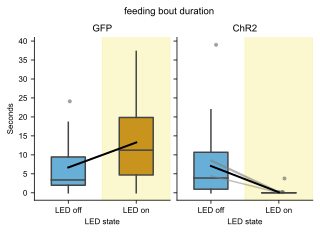

In [93]:
# virus_types = ['0_tdTomato','1_eOPN3']
virus_types = ['0_GFP','1_ChR2']
# virus_types = ['1_ChR2']
measure = 'feeding bout duration'

flierprops = dict(marker='.',markeredgecolor='none',markersize=8,linestyle='none',alpha=0.5)
medianprops = dict(color="white")
boxprops= dict(edgecolor="white")
whiskerprops = dict(color="k")

fig, axes = plt.subplots(ncols=2,sharey=True,figsize=[5,3],gridspec_kw={"wspace":0.05})
for virus_idx, virus_type in enumerate(virus_types):
    if 'GFP' in virus_type:
        color_counter = 0
    else:
        color_counter = 0
    
    df_select = df_licks_flat.query("virus==@virus_type")

    # sns.swarmplot(data=df_select,x='LED state',y='milk consumption',hue='LED state',palette=my_color_map[0:2],ax=axes[virus_idx],legend=False)
    # sns.scatterplot(data=df_select,x='LED state',y=measure,hue='LED state',palette=my_color_map[color_counter:color_counter+2],ax=axes[virus_idx],legend=False,s=50)
    sns.boxplot(data=df_select,x='LED state',y=measure,hue='LED state',palette=my_color_map[color_counter:color_counter+2],ax=axes[virus_idx],dodge=0,width=0.5,flierprops=flierprops,showcaps=False)
    axes[virus_idx].get_legend().remove()
    
    for mouse_id in df_select['mouse_id'].unique():
        y_off = df_select[(df_select['mouse_id']==mouse_id) & (df_select['LED state']=='LED off')][measure].mean()
        y_on  = df_select[(df_select['mouse_id']==mouse_id) & (df_select['LED state']=='LED on')][measure].mean()
        axes[virus_idx].plot([0,1],[y_off,y_on],color='grey',alpha=0.5,lw=1.5,zorder=10)
    y_off = df_select[(df_select['LED state']=='LED off')][measure].mean()
    y_on  = df_select[(df_select['LED state']=='LED on')][measure].mean()
    axes[virus_idx].plot([0,1],[y_off,y_on],color='k',alpha=1,lw=2,zorder=100)
    fig.suptitle(f"{measure}",y=1.02)
    axes[virus_idx].set_title(f"{virus_type.split('_')[1]}")
    sns.despine(ax=axes[virus_idx])
    axes[virus_idx].axvspan(xmin=0.5,xmax=1.5,color=my_color_map[3],alpha=0.25,zorder=-100)
    axes[virus_idx].set_xlim([-0.5,1.5])
    for artist in axes[virus_idx].lines:
        if artist.get_linestyle() == "None":
            pos = artist.get_xdata()
            artist.set_xdata(pos + np.random.uniform(-.125, .125, len(pos)))

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
# axes[1].text(x=0.5,y=175,s='$P_{virus*LED}=0.00097$',ha='center')

axes[0].set_ylabel(f"Seconds")
axes[1].set_ylabel(f"")

plot_name = f'5_opto_individual_feeding_bout_duration'
# save_plot_pdf(plot_name)



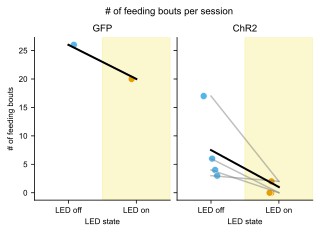

In [94]:
# virus_types = ['0_tdTomato','1_eOPN3']
virus_types = ['0_GFP','1_ChR2']
# virus_types = ['1_ChR2']
# measure = 'feeding bout duration'
measure = 'number of feeding bout'

flierprops = dict(marker='.',markeredgecolor='none',markersize=8,linestyle='none',alpha=0.5)
medianprops = dict(color="white")
boxprops= dict(edgecolor="white")
whiskerprops = dict(color="k")

fig, axes = plt.subplots(ncols=2,sharey=True,figsize=[5,3],gridspec_kw={"wspace":0.05})
for virus_idx, virus_type in enumerate(virus_types):
    if 'GFP' in virus_type:
        color_counter = 0
    else:
        color_counter = 0
    
    df_select = df_concat.query("virus==@virus_type")

    # sns.swarmplot(data=df_select,x='LED state',y='milk consumption',hue='LED state',palette=my_color_map[0:2],ax=axes[virus_idx],legend=False)
    sns.scatterplot(data=df_select,x='LED state',y=measure,hue='LED state',palette=my_color_map[color_counter:color_counter+2],ax=axes[virus_idx],legend=False,s=50)
    # sns.boxplot(data=df_select,x='LED state',y=measure,hue='LED state',palette=my_color_map[color_counter:color_counter+2],ax=axes[virus_idx],dodge=0,width=0.5,flierprops=flierprops,showcaps=False)
    # axes[virus_idx].get_legend().remove()
    
    for mouse_id in df_select['mouse_id'].unique():
        y_off = df_select[(df_select['mouse_id']==mouse_id) & (df_select['LED state']=='LED off')][measure].mean()
        y_on  = df_select[(df_select['mouse_id']==mouse_id) & (df_select['LED state']=='LED on')][measure].mean()
        axes[virus_idx].plot([0,1],[y_off,y_on],color='grey',alpha=0.5,lw=1.5,zorder=10)
    y_off = df_select[(df_select['LED state']=='LED off')][measure].mean()
    y_on  = df_select[(df_select['LED state']=='LED on')][measure].mean()
    axes[virus_idx].plot([0,1],[y_off,y_on],color='k',alpha=1,lw=2,zorder=100)
    fig.suptitle(f"# of feeding bouts per session",y=1.02)
    axes[virus_idx].set_title(f"{virus_type.split('_')[1]}")
    sns.despine(ax=axes[virus_idx])
    axes[virus_idx].axvspan(xmin=0.5,xmax=1.5,color=my_color_map[3],alpha=0.25,zorder=-100)
    axes[virus_idx].set_xlim([-0.5,1.5])
    jitter_points(ax=axes[virus_idx])

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
# axes[1].text(x=0.5,y=32.5,s='$P_{virus*LED}=0.824$',ha='center')

axes[0].set_ylabel(f"# of feeding bouts")
axes[1].set_ylabel(f"")
plot_name = f'5_opto_feeding_bout_number'
# save_plot_pdf(plot_name)



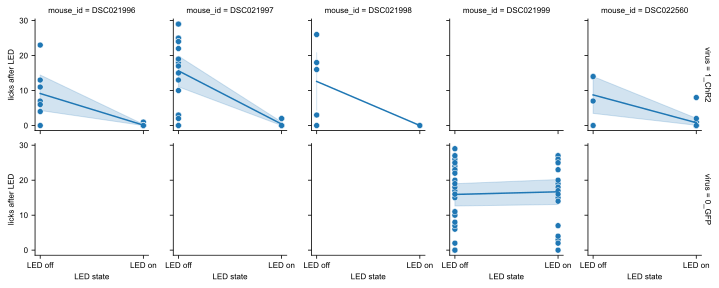

In [95]:
df_licks_flat.to_csv('/Users/hunglo/Documents/inscopix_csv/opto_csv_chr2/processed_csv/opto_data_licks.csv',index=False)


# plt.figure(figsize=[4,4])
g = sns.FacetGrid(data=df_licks_flat,col='mouse_id',row='virus',height=2,aspect=1, margin_titles=True)
g.map_dataframe(sns.lineplot,x='LED state',y='licks after LED')
g.map_dataframe(sns.scatterplot,x='LED state',y='licks after LED')

# g = sns.relplot(data=df_licks_flat,x='LED state',y='licks after LED',hue='mouse_id',kind='line',col='virus',height=4,aspect=0.5,palette=my_color_map)
# g.map(scatterplot)
# sns.stripplot(data=df_licks_flat,x='LED state',y='licks after LED',hue='mouse_id')
# plt.ylim(ymin=0)

sns.despine()
plt.tight_layout()
# sns.lineplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',ci=None,palette=my_color_map_select,ax=ax)
# sns.swarmplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',palette=my_color_map_select,ax=ax,alpha=0.7,size=6)

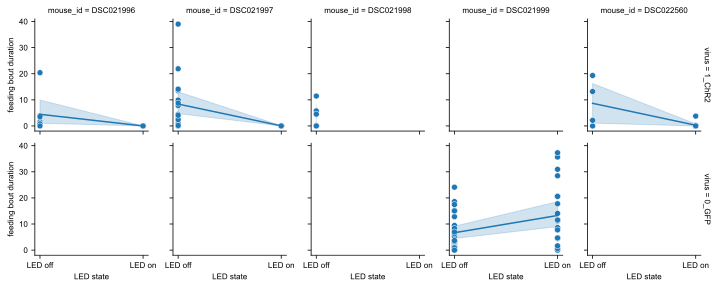

In [96]:
g = sns.FacetGrid(data=df_licks_flat,col='mouse_id',row='virus',height=2,aspect=1, margin_titles=True)
g.map_dataframe(sns.lineplot,x='LED state',y='feeding bout duration')
g.map_dataframe(sns.scatterplot,x='LED state',y='feeding bout duration')



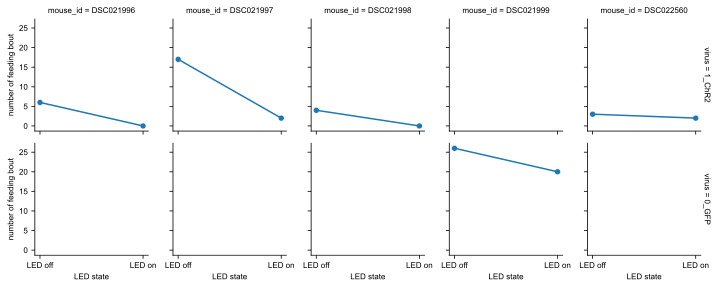

In [97]:
g = sns.FacetGrid(data=df_concat,col='mouse_id',row='virus',height=2,aspect=1, margin_titles=True)
g.map_dataframe(sns.lineplot,x='LED state',y='number of feeding bout')
g.map_dataframe(sns.scatterplot,x='LED state',y='number of feeding bout')



In [98]:
## get data from dict and organize them into pd.DataFrame

keys = sorted(milk_dict.keys())

## If you only want to check one mouse then use the follow code:
# mouse_id = 'DSC019649'
# select_key = [key for key in keys if mouse_id in key]

select_key = keys

df_list = [] # a list to hold all pd.DataFrame

# also get lick data
for key in select_key:
    mouse_id = key.split('_')[0]
    date = key.split('_')[-1]
    if date in LED_on_date_list:
        LED_state = 'LED on'
    else:
        LED_state = 'LED off'
    milk_pump = milk_dict.get(key)
    milk_consumption = len(milk_dict.get(key))
    licks = len(lick_dict.get(key))
    duration = duration_dict.get(key)
    duration_LED = duration_LED_dict.get(key) 
    baseline_finish_time = baseline_dict.get(key)
    df_ = pd.DataFrame([mouse_id,date,LED_state,milk_consumption,licks,duration,duration_LED,milk_pump,baseline_finish_time])
    df_list.append(df_)

## Convert list to a large dataframe

df_concat = pd.DataFrame([np.zeros(df_.shape[0])]).T
for i in range(len(df_list)):
    df_concat = pd.concat([df_concat,df_list[i]],axis=1)

df_concat = df_concat.iloc[:,1:]
df_concat = df_concat.T
df_concat = df_concat.rename(columns={0 : "mouse_id",1:'date',2:'LED state',3:'milk consumption',4:'lick',5:'feeding duration',6:'feeding duration after closed-loop trigger',7:'milk pump',8:'baseline time'}).reset_index(drop=True)

## Add additional info to the dataframe

## add session number
## this is assumed that the order of these files are sorted with mouse ids, so make sure this is the case. (should be fine here)

day_list = []
for mouse_id in df_concat['mouse_id'].unique():
    df_short = df_concat[df_concat['mouse_id']==mouse_id]
    day_list_temp = []
    for date in df_short['date']:
        for idx,_ in enumerate(sorted(df_short['date'].unique())):
            if date == _:
                day_list_temp.append(int(idx+1))
    day_list.append(day_list_temp)
day_list = [i for sublist in day_list for i in sublist]
df_concat['session']=day_list
## also convert date to int for future merging
df_concat['date'] = df_concat['date'].astype(int)

## add viral type here
# eOPN3_list = ['DSC019649','DSC019650','DSC019651','DSC019652']
ChR2_list = ['DSC021996','DSC021997','DSC021998','DSC022560']
viral_list = []
for idx,mouse_id in enumerate(df_concat['mouse_id']):
    if mouse_id in ChR2_list:
        viral_list.append('1_ChR2') # prefix here is just to force control to be 0 and opto to be 1, so the mixed model later is easier to interpret
    else:
        viral_list.append('0_GFP')
df_concat['virus']=viral_list


## add sex info here
# female_list = ['DSC019651','DSC019652','DSC020469','DSC020470']
female_list = ['DSC022560','DSC022561','DSC022675']
sex_list = []
for idx,mouse_id in enumerate(df_concat['mouse_id']):
    if mouse_id in female_list:
        sex_list.append('Female')
    else:
        sex_list.append('Male')
df_concat['sex']=sex_list

## Note that body weight info is stored separately, will add in the last cell before saving the csv file



In [99]:
df_concat

,mouse_id,date,LED state,milk consumption,lick,feeding duration,feeding duration after closed-loop trigger,milk pump,baseline time,session,virus,sex
0,DSC021996,240318,LED off,105,247,72.095996,31.187988,"[311.975004, 312.670999, 477.801997, 479.54099...",880.630002,1,1_ChR2,Male
1,DSC021996,240319,LED on,78,172,37.468024,0.0,"[343.334004, 349.960003, 352.281001, 353.40100...",62.639004,2,1_ChR2,Male
2,DSC021997,240318,LED off,268,1050,216.798993,159.250975,"[404.456, 405.538998, 406.419, 407.280994, 407...",116.849,1,1_ChR2,Male
3,DSC021997,240319,LED on,74,355,52.299995,0.377998,"[361.064995, 361.652999, 363.731999, 364.693, ...",76.420997,2,1_ChR2,Male
4,DSC021998,240318,LED off,74,266,58.953001,21.890002,"[398.598002, 399.948002, 400.762996, 402.04499...",311.130001,1,1_ChR2,Male
5,DSC021998,240319,LED on,19,38,7.832998,0.0,"[569.968998, 1787.263998, 2000.793001, 2576.01...",3265.063005,2,1_ChR2,Male
6,DSC021999,240318,LED off,336,1417,283.529995,193.707997,"[359.843006, 361.846009, 362.617007, 363.21200...",73.826008,1,0_GFP,Male
7,DSC021999,240319,LED on,395,1909,362.977013,291.935994,"[304.12, 305.141999, 306.543001, 307.181998, 3...",17.260999,2,0_GFP,Male
8,DSC022560,240318,LED off,83,221,71.509003,34.673003,"[396.985, 840.461002, 842.399999, 845.706001, ...",617.628998,1,1_ChR2,Female
9,DSC022560,240319,LED on,99,269,66.868012,3.966995,"[313.075005, 313.693007, 315.070007, 315.661, ...",25.120003,2,1_ChR2,Female


In [100]:
def cumulative_plots(df_select,virus_type):
    t_led_on_mouse = []
    t_led_off_mouse = []

    for n, mouse_id in enumerate(df_select['mouse_id'].unique()):
        # add a new subplot iteratively
        ax = plt.subplot(1, len(df_select['mouse_id'].unique())+1, n + 1)
        i_on, i_off = 0, 0
        t_led_on, t_led_off = [], []

        for idx,date in enumerate(df_select[df_select['mouse_id']==mouse_id]['date']):
            if str(date) in LED_on_date_list:
                t = df_select[df_select['mouse_id']==mouse_id].iloc[idx]['milk pump']
                t_led_on.append(t)
                i_on+=1
            else:
                t = df_select[df_select['mouse_id']==mouse_id].iloc[idx]['milk pump']
                t_led_off.append(t)
                i_off+=1

        ## plot average line for each mouse subplot
        ## plot the avg line first so legend is with full colors, not the transparent ones
        if t_led_on !=[]:
            t_led_on_flat = sorted(np.concatenate(t_led_on).ravel())
            ax.plot(t_led_on_flat,np.array(range(1,len(t_led_on_flat)+1))/i_on,c=my_color_map[1],lw=2)
        else:
            pass
        t_led_off_flat = sorted(np.concatenate(t_led_off).ravel())
        ax.plot(t_led_off_flat,np.array(range(1,len(t_led_off_flat)+1))/i_off,c=my_color_map[0],lw=2)

        for t in t_led_on:
            ax.plot(t,range(1,len(t)+1),c=my_color_map[1],alpha=0.25,lw=1)
        for t in t_led_off:
            ax.plot(t,range(1,len(t)+1),c=my_color_map[0],alpha=0.25,lw=1)

        ax.legend([f'LED on: {i_on}',f'LED off: {i_off}'],frameon=False,loc=4)
        ax.set_title(f'{mouse_id}')
        ax.set_xlabel('Time (sec)')
        ax.set_ylabel('Cum. milk consumption')
        sns.despine(ax=ax)
        # ax.set_ylim([-10,510])

    # plot all trial together in last subplot
    ax = plt.subplot(1, len(df_select['mouse_id'].unique())+1, n + 2)
    i_on = 0
    i_off = 0
    for idx,date in enumerate(df_select['date']):
        if str(date) in LED_on_date_list:
            t = df_select.iloc[idx]['milk pump']
            i_on+=1
        else:
            t = df_select.iloc[idx]['milk pump']
            i_off+=1

    i_on, i_off = 0, 0
    t_led_on, t_led_off = [], []

    # plot average line
    for idx,date in enumerate(df_select['date']):
        if str(date) in LED_on_date_list:
            t_led_on.append(df_select.iloc[idx]['milk pump'])
            i_on+=1
        else:
            t_led_off.append(df_select.iloc[idx]['milk pump'])
            i_off+=1
    if t_led_on !=[]:
        t_led_on_flat = sorted(np.concatenate(t_led_on).ravel())
        ax.plot(t_led_on_flat,np.array(range(1,len(t_led_on_flat)+1))/i_on,c=my_color_map[1],lw=2)
    t_led_off_flat = sorted(np.concatenate(t_led_off).ravel())    
    ax.plot(t_led_off_flat,np.array(range(1,len(t_led_off_flat)+1))/i_off,c=my_color_map[0],lw=2)
    ax.legend([f'LED on: {i_on}',f'LED off: {i_off}'],frameon=False,loc=4)

    # plot individual lines
    for t in t_led_on:
        ax.plot(t,range(1,len(t)+1),c=my_color_map[1],alpha=0.25)

    for t in t_led_off:
        ax.plot(t,range(1,len(t)+1),c=my_color_map[0],alpha=0.25)
    
    ax.set_title(f'All trials')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Cum. milk consumption')
    sns.despine(ax=ax)
    # ax.set_ylim([-10,510])


In [101]:
def cumulative_plots_norm(df_select,virus_type):

    t_led_on_mouse = []
    led_off_max_mouse = []
    t_led_off_mouse = []

    for n, mouse_id in enumerate(df_select['mouse_id'].unique()):
        print(mouse_id)
        # add a new subplot iteratively
        ax = plt.subplot(1, len(df_select['mouse_id'].unique())+1, n + 1)
        i_on, i_off = 0, 0
        t_led_on, t_led_off = [], []

        for idx,date in enumerate(df_select[df_select['mouse_id']==mouse_id]['date']):
            if str(date) in LED_on_date_list:
                t = df_select[df_select['mouse_id']==mouse_id].iloc[idx]['milk pump']
                print('LED on loop here')
                t_led_on.append(t)
                i_on+=1
            else:
                t = df_select[df_select['mouse_id']==mouse_id].iloc[idx]['milk pump']
                t_led_off.append(t)
                i_off+=1

        ## plot average line for each mouse subplot
        if t_led_on !=[]:
            t_led_on_flat = sorted(np.concatenate(t_led_on).ravel())
        else:
            pass
        t_led_off_flat = sorted(np.concatenate(t_led_off).ravel())

        ax.set_title(f'{mouse_id}')
        ax.set_xlabel('Time (sec)')
        ax.set_ylabel('Cum. milk consumption norm.')
        sns.despine(ax=ax)
        # ax.set_ylim([-10,510])

        ## normalize to LED off average max for each mouse and save for average plots
        led_off_max = np.max(np.array(range(1,len(t_led_off_flat)+1))/i_off)

        # shrink the y value (numbers of pump activations)
        # plot average LED on & LED off first, so the ax legend is more visible
        ax.plot(t_led_on_flat,np.array(range(1,len(t_led_on_flat)+1))/led_off_max/i_on,c=my_color_map[1],lw=2)
        ax.plot(t_led_off_flat,np.array(range(1,len(t_led_off_flat)+1))/led_off_max/i_off,c=my_color_map[0],lw=2)
        ax.legend([f'LED on: {i_on}',f'LED off: {i_off}'],frameon=False,loc=4)

        x_avg_on_mouse, y_avg_on_mouse = [],[]
        x_avg_off_mouse, y_avg_off_mouse = [],[]
        x_avg_on_mouse.append(t_led_on_flat)
        y_avg_on_mouse.append(np.array(range(1,len(t_led_on_flat)+1))/led_off_max/i_on)
        x_avg_off_mouse.append(t_led_off_flat)
        y_avg_off_mouse.append(np.array(range(1,len(t_led_off_flat)+1))/led_off_max/i_off)

        for t in t_led_on:
            ax.plot(t,np.array(range(1,len(t)+1))/led_off_max,c=my_color_map[1],lw=1,alpha=0.25)
        t_led_on_mouse.append(t_led_on)
        led_off_max_mouse.append(led_off_max)

        for t in t_led_off:
            ax.plot(t,np.array(range(1,len(t)+1))/led_off_max,c=my_color_map[0],lw=1,alpha=0.25)
        t_led_off_mouse.append(t_led_off)

    ## plot the normalized lines to the last subplot
    trial_num_on = len(t_led_on)*len(t_led_on_mouse)
    trial_num_off = len(t_led_off)*len(t_led_off_mouse)
    
    ## add last subplot for all trials together
    ax = plt.subplot(1, len(df_select['mouse_id'].unique())+1, n + 2)
    ## concat & ravel
    x_flat = np.array(sorted(np.concatenate(x_avg_on_mouse).ravel()))
    y_flat = np.array(sorted(np.concatenate(y_avg_on_mouse).ravel()))
    ax.plot(x_flat,y_flat,c=my_color_map[1],lw=2)

    x_flat = np.array(sorted(np.concatenate(x_avg_off_mouse).ravel()))
    y_flat = np.array(sorted(np.concatenate(y_avg_off_mouse).ravel()))
    ax.plot(x_flat,y_flat,c=my_color_map[0],lw=2)
    ax.legend([f'LED on: {trial_num_on}',f'LED off: {trial_num_off}'],frameon=False,loc=4)
    for idx,t_list in enumerate(t_led_on_mouse):
        for t in t_list:
            ax.plot(t,np.array(range(1,len(t)+1))/led_off_max_mouse[idx],c=my_color_map[1],lw=1,alpha=0.2)
    
    for idx,t_list in enumerate(t_led_off_mouse):
        for t in t_list:
            ax.plot(t,np.array(range(1,len(t)+1))/led_off_max_mouse[idx],c=my_color_map[0],lw=1,alpha=0.2)
    ax.set_title(f'All trials')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Cum. milk consumption norm.')
    sns.despine(ax=ax)


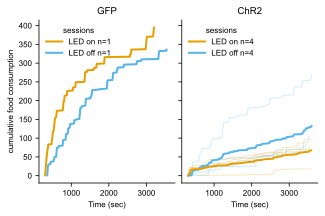

In [104]:

t_led_on_mouse = []
t_led_off_mouse = []


fig, axes = plt.subplots(ncols=2,sharex=True,sharey=True,figsize=[5,3],gridspec_kw={"wspace":0.05})

color_counter = 0
for plot_idx, virus in enumerate(['0_GFP','1_ChR2']):
# for plot_idx, virus in enumerate(['1_ChR2']):
    if 'GFP' in virus:
        color_counter = 0
        ls = '-'
    else:
        color_counter = 0
        ls='-'

    df_select = df_concat[df_concat['virus']==virus]

    i_on = 0
    i_off = 0
    for idx,date in enumerate(df_select['date']):
        if str(date) in LED_on_date_list:
            t = df_select.iloc[idx]['milk pump']
            i_on+=1
        else:
            t = df_select.iloc[idx]['milk pump']
            i_off+=1

    i_on, i_off = 0, 0
    t_led_on, t_led_off = [], []

    # plot average line
    for idx,date in enumerate(df_select['date']):
        if str(date) in LED_on_date_list:
            t_led_on.append(df_select.iloc[idx]['milk pump'])
            i_on+=1
        else:
            t_led_off.append(df_select.iloc[idx]['milk pump'])
            i_off+=1
    if t_led_on !=[]:
        t_led_on_flat = sorted(np.concatenate(t_led_on).ravel())
        axes[plot_idx].plot(t_led_on_flat,np.array(range(1,len(t_led_on_flat)+1))/i_on,c=my_color_map[color_counter+1],lw=2,zorder=100,ls=ls)
    t_led_off_flat = sorted(np.concatenate(t_led_off).ravel())    
    axes[plot_idx].plot(t_led_off_flat,np.array(range(1,len(t_led_off_flat)+1))/i_off,c=my_color_map[color_counter],lw=2,zorder=50,ls=ls)
    axes[plot_idx].legend([f'LED on n={i_on}',f'LED off n={i_off}'],frameon=False,loc=2,title='sessions')

    # plot individual lines
    for t in t_led_on:
        axes[plot_idx].plot(t,range(1,len(t)+1),c=my_color_map[color_counter+1],alpha=0.25,lw=1,ls=ls)

    for t in t_led_off:
        axes[plot_idx].plot(t,range(1,len(t)+1),c=my_color_map[color_counter],alpha=0.25,lw=1,ls=ls)

    axes[plot_idx].set_title(f"{virus.split('_')[-1]}")
    axes[plot_idx].set_xlabel('Time (sec)')
    if plot_idx==0:
        axes[plot_idx].set_ylabel('cumulative food consumption')
    sns.despine(ax=axes[plot_idx])
# ax.set_ylim([-10,510])

def save_plot_pdf(plot_name):
    fig_output_folder = '/Users/hunglo/Documents/inscopix_csv/fig_output/'
    kwargs = {"facecolor":"white","dpi":300,"bbox_inches":"tight"}
    # kwargs = {"facecolor":"white","dpi":300} # no tight arg here, to prevent fontsize changes
    plt.savefig(f'{fig_output_folder}{plot_name}.pdf',**kwargs)



plot_name = '5_cumu_ensure_consumption'
# save_plot_pdf(plot_name)

In [105]:
# ## make an eventplot here to just show some example trials

# interval = 4 ## sec, defined for when a feeding bout is discontinued and separated into a different feeding bout
# # LED_on_date_list = ['230106','230110','230112','230114','230117','230120','230221','230223','230225','230228','230302','230304']
# LED_on_date_list = ['240319','240321','240323','240326','240328','240330'] # for ChR2 batch 1

# file_folder = '/Users/hunglo/Documents/inscopix_csv/opto_csv_chr2/csv_folder/' # path where we have all the opto data in csv format
# fig_output_folder = '/Users/hunglo/Documents/inscopix_csv/opto_csv/fig_output/'
# file_path_list = [f for f in listdir(file_folder) if isfile(join(file_folder, f))]
# file_path_list = sorted([f for f in file_path_list if '_.csv' in f])

# show_plot = False

# for file in file_path_list[0:5]:
#     file_path = join(file_folder,file)
#     # mouse_id, date, LED_state, L1_timestamps_new, Pump1_new, Pump2_new, feeding_epoch, df, baseline_finish_time = return_stats(file_path,LED_on_date_list,interval)
#     mouse_id, date, LED_state, L1_timestamps_new, Pump1_new, Pump2_new, feeding_epoch, df, df_licks, baseline_finish_time = return_stats(file_path,LED_on_date_list,interval)
#     # mouse_id, date, LED_state, L1_timestamps_new, Pump1_new, Pump2_new, feeding_epoch, df, df_licks, baseline_finish_time


In [106]:
# ## feeding bout plotting

# def plot_bout_lick(Pump1_new, Pump2_new, L1_timestamps_new, feeding_epoch, plot_led = False,ax=None):
#     from matplotlib.ticker import FormatStrFormatter
#     xlim_range = [-2,60]
#     # plt.figure(figsize=[4,3])
#     trial_num = 1 # make it 1-index
#     bout_skip = 1
#     total_trial = len(feeding_epoch['start'][bout_skip:])
#     for idx, timestamp in enumerate(feeding_epoch['start'][bout_skip:]):
#         if plot_led:
#             event_color = my_color_map[1]
#         else:
#             event_color = my_color_map[0]

#         if feeding_epoch['end'][bout_skip:].iloc[idx]-timestamp<1:
#             continue
#         Pump1_select = Pump1_new[Pump1_new>(timestamp-1)]
#         Pump1_select = Pump1_select[Pump1_select<feeding_epoch['end'][bout_skip:].iloc[idx]]
#         Pump2_select = Pump2_new[Pump2_new>(timestamp-1)]
#         Pump2_select = Pump2_select[Pump2_select<feeding_epoch['end'][bout_skip:].iloc[idx]]
#         L1_select = L1_timestamps_new[L1_timestamps_new>(timestamp-0.2)]
#         L1_select = L1_select[L1_select<feeding_epoch['end'][bout_skip:].iloc[idx]] # only plot licks in the first feeding bout
#         ax.eventplot([Pump1_select-timestamp],linelengths = [0.65],linewidths = [0.7], colors=event_color,lineoffsets = [trial_num]) # ensure pump
#         # ax.plot((Pump1_select-timestamp),np.ones(len(Pump1_select-timestamp))*trial_num,ls='',marker='.',color=my_color_map[1],markersize=4,alpha=1) #,marker='|'
        

#         # plt.eventplot([L1_select-timestamp],linelengths = [0.4],linewidths = [0.4], colors='k',lineoffsets = [trial_num]) # licks

#         # plt.plot([0,feeding_epoch['end'][1:][idx+1]-timestamp],[trial_num,trial_num],ls='-',lw=5,color='grey',alpha=0.5,zorder=-100)
#         if plot_led:
#             ax.plot((Pump2_select-timestamp),np.ones(len(Pump2_select-timestamp))*trial_num,ls='',marker='.',color='k',markersize=4,alpha=1) #,marker='|'

#         x = feeding_epoch[feeding_epoch['start']>=timestamp]['start'][0] # take only the first value
#         y = feeding_epoch[feeding_epoch['start']>=timestamp]['end'][0] # take only the first value
#         # # for x,y in zip(feeding_epoch['start'][2:],feeding_epoch['end'][2:]):
#         # if y-x>1:
#         #     # if y< timestamp+xlim_range[-1]:
#         #     # plt.plot([x-timestamp,y-timestamp],[trial_num,trial_num],ls='-',lw=int(150/total_trial/1.5),color='grey',alpha=0.5,zorder=-100)
#         #     plt.plot([x-timestamp,y-timestamp],[trial_num,trial_num],ls='-',lw=5,color='grey',zorder=-100,alpha=0.4)
#         #         if counter>0: # so we only plot the first feeding event here
#         #             continue
#         # # for i in range(2):
#         #     plt.plot([feeding_epoch['start'][1:0][idx+1+i]-timestamp,feeding_epoch['end'][1:][idx+1+i]-timestamp],[trial_num,trial_num],ls='-',lw=5,color='grey',alpha=0.5,zorder=-100)
#         trial_num+=1
#     if plot_led:
#         ax.legend(['food pump event','LED'],frameon=False,loc=[0.3,0.6])
#         ax.set_title('eOPN3: Closed-loop LED on')
#     else:
#         ax.legend(['food pump event'],frameon=False,loc=[0.3,0.68])
#         ax.set_title('eOPN3: LED off')
#         # ax = plt.gca()
#         # ax.get_legend().remove()

#     # plt.axvline(x=0,ls=':',c='k')
#     # ax = plt.gca()
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#     # plt.tight_layout()
#     ax.set_xlim(xlim_range)
#     # ax.ylim([0,trial_num])
#     ax.set_yticks([0,5,10,15])
#     sns.despine(ax=ax)
#     # plt.xticks([0,5,10,15,20,25,30])
#     # ax.set_ylabel('# of feeding bouts')
#     ax.set_xlabel('Time from feeding bout onest (sec)')

# # plot_bout_lick(Pump1_new, Pump2_new, L1_timestamps_new, feeding_epoch, plot_led = True)
# # plot_name = '6_LED_on_example'
# # save_plot_pdf(plot_name)

In [107]:
# fig,axes = plt.subplots(ncols=2,figsize=[5.5,2.5],sharey=True,gridspec_kw={'wspace':0.1})

# # for idx, file in enumerate(file_path_list[20:22]): # 15/16 is good
# for idx, file in enumerate(file_path_list[0:2]): # 15/16 is good
#     file_path = join(file_folder,file)
#     # mouse_id, date, LED_state, L1_timestamps_new, Pump1_new, Pump2_new, feeding_epoch, df, baseline_finish_time = return_stats(file_path,LED_on_date_list,interval)
#     mouse_id, date, LED_state, L1_timestamps_new, Pump1_new, Pump2_new, feeding_epoch, df, df_licks, baseline_finish_time = return_stats(file_path,LED_on_date_list,interval)
#     Pump2_new = make_20hz_5pulse(Pump2_new)

#     if date in LED_on_date_list:
#         plot_led = True
#     #     plot_name = '6_LED_on_example'
#     else:
#         plot_led = False
#     #     plot_name = '6_LED_off_example'        
#     plot_bout_lick(Pump1_new, Pump2_new, L1_timestamps_new, feeding_epoch, plot_led = plot_led,ax=axes[idx])
#     if idx ==0:
#         axes[idx].set_ylabel('# of feeding bouts')
#     axes[idx].set_ylim([0,19])
#     print(f"{mouse_id}_{date}")
#     # plt.show()
# plot_name = '5_feeding_bout_traces'
# # save_plot_pdf(plot_name)

UnboundLocalError: local variable 't_led_on' referenced before assignment

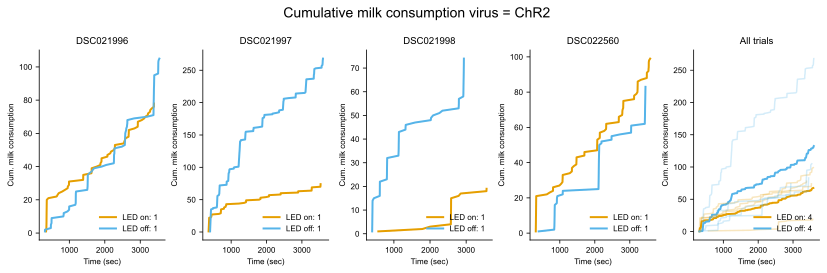

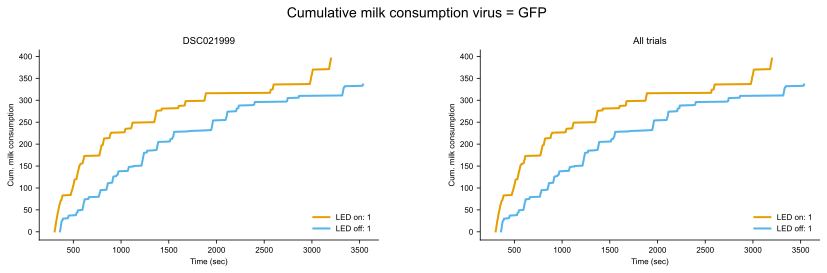

<Figure size 1008x252 with 0 Axes>

In [108]:
# cumulative plot
# virus_types = ['1_eOPN3','0_tdTomato']
virus_types = ['1_ChR2','0_GFP']


for virus_type in virus_types:

    plt.figure(figsize=(14, 3.5))
    plt.subplots_adjust(hspace=0.5,wspace=0.3)

    df_select = df_concat.query("virus==@virus_type")
    plt.suptitle(f"Cumulative milk consumption virus = {virus_type.split('_')[-1]}", fontsize=14, y=1.05)
    cumulative_plots(df_select=df_select,virus_type=virus_type)
    # plt.savefig(f"{fig_output_folder}cum_milk_plot_{virus_type.split('_')[-1]}.png",dpi=300,facecolor='w',bbox_inches='tight')


## cumulative plot
virus_types = ['1_eOPN3','0_tdTomato']

for virus_type in virus_types:

    plt.figure(figsize=(14, 3.5))
    plt.subplots_adjust(hspace=0.5,wspace=0.3)

    df_select = df_concat.query("virus==@virus_type")
    plt.suptitle(f"Cumulative milk consumption (norm.) virus = {virus_type.split('_')[-1]}", fontsize=14, y=1.05)
    cumulative_plots_norm(df_select=df_select,virus_type=virus_type)
    # plt.savefig(f"{fig_output_folder}cum_milk_plot_{virus_type.split('_')[-1]}_norm.png",dpi=300,facecolor='w',bbox_inches='tight')


In [109]:
def opto_behavior_summary(df_select,virus_type,normalize):
    if normalize:
        df_select = normalize_df(df_select)
    else:
        pass

    ## make a dict of y axis labels
    y_labels = {'milk consumption':'# of pump activations',
                'lick': '# of lick events',
                'feeding duration': 'Seconds',
                'feeding duration after closed-loop trigger': 'Seconds',
                }

    col_names = df_select.columns
    col_names = [col for col in col_names if col not in ['mouse_id','date','LED state','session','milk pump','virus','sex','baseline time']]
    col_names = ['milk consumption','lick','feeding duration','feeding duration after closed-loop trigger']


    n_mice = len(df_select['mouse_id'].unique())
    n_mice = len(df_select['mouse_id'].unique())
    my_color_map_select = my_color_map[0:n_mice]
    # loop through the length of tickers and keep track of index
    for n, subplot in enumerate(col_names):
        # add a new subplot iteratively
        ax = plt.subplot(1, len(col_names), n + 1)
        sns.lineplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',ci=None,palette=my_color_map_select,ax=ax)
        sns.swarmplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',palette=my_color_map_select,ax=ax,alpha=0.7,size=6)
        sns.despine(ax=ax)

        ax.axvspan(xmin=0.5,xmax=1.5,alpha=0.2,color=my_color_map[3])
        if 'trigger' in subplot:
            ax.set_title('feeding duration after\nclosed-loop trigger')
        else:
            ax.set_title(subplot)
        # plt.ylim(ymin=0)
        if normalize:
            ax.set_ylabel('Normalized')
        else:
            ax.set_ylabel(y_labels[subplot])

        if n == len(col_names)-1: # label the last subplot with legend outside
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),frameon=False)
        else:
            ax.get_legend().remove()
        ax.set_xlim([-0.5,1.5])
    # plt.show()
    ## here are the codes for showing each measures against exp sessions
    ## use mapping here for sns.lineplot

def opto_behavior_summary_session(df_select,virus_type,normalize):
    if normalize:
        df_select = normalize_df(df_select)
    else:
        pass

    ## make a dict of y axis labels
    y_labels = {'milk consumption':'# of pump activations',
                'lick': '# of lick events',
                'feeding duration': 'Seconds',
                'feeding duration after closed-loop trigger': 'Seconds',
                }

    col_names = df_select.columns
    col_names = [col for col in col_names if col not in ['mouse_id','date','LED state','session','milk pump','virus','sex','baseline time']]
    col_names = ['milk consumption','lick','feeding duration','feeding duration after closed-loop trigger']

    n_mice = len(df_select['mouse_id'].unique())
    n_mice = len(df_select['mouse_id'].unique())
    my_color_map_select = my_color_map[0:n_mice]

    # plt.subplots_adjust(hspace=0.5,wspace=0.5)
    # plt.suptitle("Opto-suppression in aPC upon feeding", fontsize=14, y=1.05)
    # plt.suptitle(f"Opto-suppression in aPC upon feeding virus = {virus_type}", fontsize=14, y=1.05)
    # for subplot in col_names:
    for n, subplot in enumerate(col_names):
        # add a new subplot iteratively
        ax = plt.subplot(1, len(col_names), n + 1)
        sns.pointplot(data=df_select,x='session',y=subplot,palette=my_color_map_select,hue='mouse_id')
        sns.despine()
        session_num = df_select['session'].max()
        for i in range(session_num//2):
            ax.axvspan(xmin=i*2+0.5,xmax=i*2+1.5,alpha=0.2,color=my_color_map[3])
        if 'trigger' in subplot:
            ax.set_title('feeding duration after\nclosed-loop trigger')
        else:
            ax.set_title(subplot)

        if normalize:
            ax.set_ylabel('Normalized')
        else:
            ax.set_ylabel(y_labels[subplot])

        # plt.ylim(ymin=0)
        plt.xlim(xmin=-0.5)
        if n == len(col_names)-1: # label the last subplot with legend outside
            sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1),frameon=False)
        else:
            ax.get_legend().remove()

def normalize_df(df_concat):
    col_names = df_concat.columns
    col_names = [col for col in col_names if col not in ['mouse_id','date','LED state','session','milk pump','virus','sex','licks after LED','feeding bout duration']]
    col_names = ['milk consumption','lick','feeding duration','feeding duration after closed-loop trigger']

    n_mice = len(df_concat['mouse_id'].unique())

    df_concat_norm = df_concat.copy()
    for mouse_id in df_concat['mouse_id'].unique():
        sub_df = df_concat[(df_concat['LED state']=='LED off') & (df_concat['mouse_id']==mouse_id)]
        for col_idx,sub_col in enumerate(col_names):
            mean_value = sub_df[sub_col].mean()
            # mean_value = sub_df[sub_col].median()
            df_concat_norm.loc[df_concat_norm['mouse_id']==mouse_id,sub_col] = df_concat_norm.loc[df_concat_norm['mouse_id']==mouse_id,sub_col]/mean_value

    ## rename columns ## currently disabled, it's easier to handle with same column names for later analysis
    # keep_same = {'mouse_id', 'date','LED state','session','milk pump','virus','lick'}
    # df_concat_norm.columns = [f"{c}{'' if c in keep_same else ' (norm.)'}" for c in df_concat_norm.columns]

    return df_concat_norm



/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_25263/3184214602.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',ci=None,palette=my_color_map_select,ax=ax)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_25263/3184214602.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',ci=None,palette=my_color_map_select,ax=ax)


/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_25263/3184214602.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',ci=None,palette=my_color_map_select,ax=ax)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_25263/3184214602.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',ci=None,palette=my_color_map_select,ax=ax)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_25263/3184214602.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_select,x='LED state',y=subplot,hue='mouse_id',ci=None,palette=my_color_map_select,ax=ax)
/var/folders/tr/w74ws6917z15hn3t5x_l367r0000gn/T/ipykernel_25263/3184214602.py:26: FutureWarning: 

The `ci` parameter is deprecated. Us

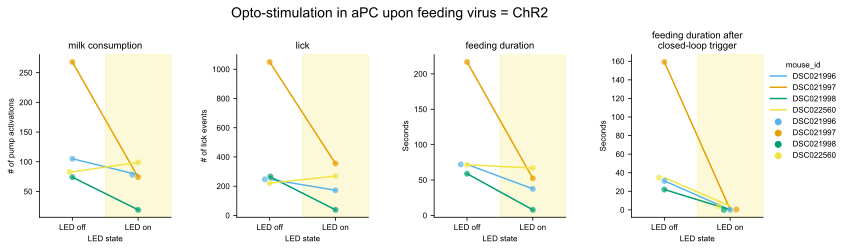

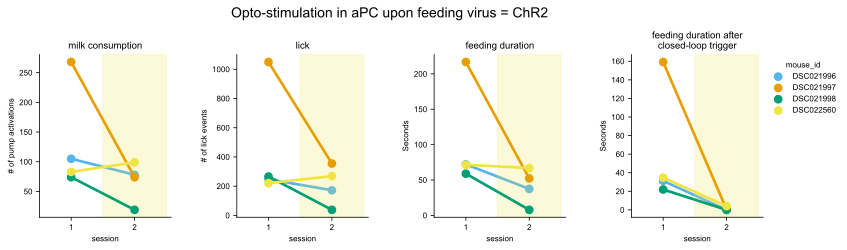

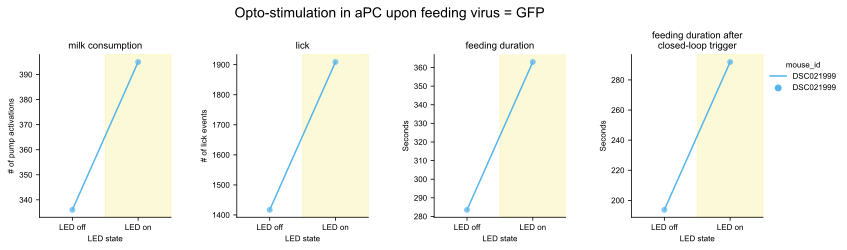

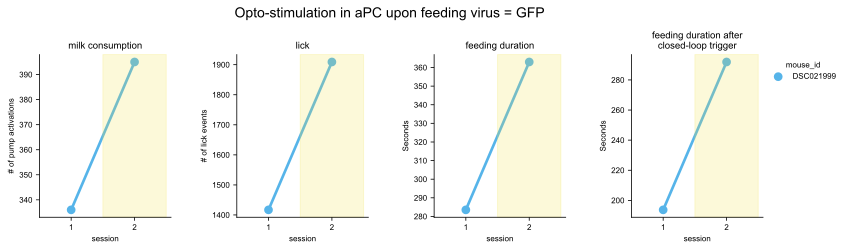

In [110]:
## plot behavior summary, with or without normalization to baseline (LED off state)

## fix plotting function & normalized function so that it doesn't plot them out

virus_types = df_concat['virus'].unique()
normalize = 0
figsize=(13, 3)

for virus_type in virus_types:

    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    df_select = df_concat.query("virus==@virus_type")
    plt.suptitle(f"Opto-stimulation in aPC upon feeding virus = {virus_type.split('_')[-1]}", fontsize=14, y=1.1)
    opto_behavior_summary(df_select,virus_type,normalize=normalize)
    # plt.savefig(f"{fig_output_folder}opto_summary_plot_{virus_type.split('_')[-1]}.png",dpi=300,facecolor='w',bbox_inches='tight')

    plt.figure(figsize=figsize)
    plt.subplots_adjust(hspace=0.5,wspace=0.5)
    df_select = df_concat.query("virus==@virus_type")
    plt.suptitle(f"Opto-stimulation in aPC upon feeding virus = {virus_type.split('_')[-1]}", fontsize=14, y=1.1)
    opto_behavior_summary_session(df_select,virus_type,normalize=normalize)
    # plt.savefig(f"{fig_output_folder}opto_session_plot_{virus_type.split('_')[-1]}.png",dpi=300,facecolor='w',bbox_inches='tight')
    


In [ ]:
df_concat

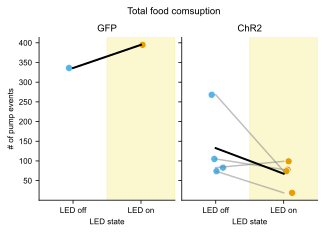

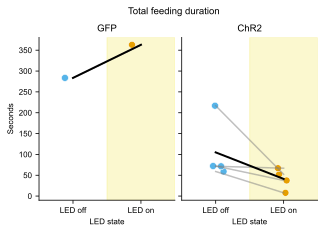

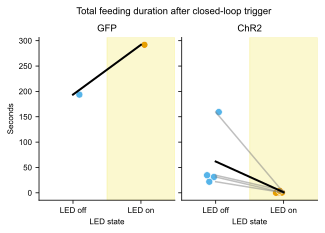

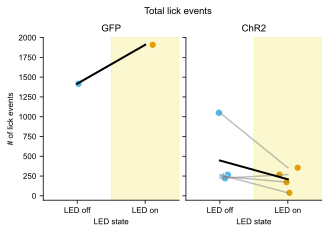

In [111]:
def jitter_points(ax):
    for points in axes[virus_idx].collections:
        vertices = points.get_offsets().data
    if len(vertices) > 0:
        vertices[:, 0] += np.random.uniform(-0.15, 0.15, vertices.shape[0])
        points.set_offsets(vertices)





virus_types = sorted(df_concat['virus'].unique())
normalize = 0
# figsize=(13, 3)

title_dict = {
    "milk consumption": "Total food comsuption",
    "feeding duration": "Total feeding duration",
    "feeding duration after closed-loop trigger":"Total feeding duration after closed-loop trigger",
    "lick":"Total lick events",
}

unit_dict = {
    "milk consumption": "# of pump events",
    "feeding duration": "Seconds",
    "feeding duration after closed-loop trigger":"Seconds",
    "lick":"# of lick events",
}

measure = 'milk consumption'
measures = ['milk consumption','feeding duration','feeding duration after closed-loop trigger','lick']

## edit this once we have all the data
# mixed_stats = {'milk consumption': 0.0006488,
#                'feeding duration': 0.02272,
#                'feeding duration after closed-loop trigger': 0.0001681,
#                'lick': 0.002935,
#            }

for measure in measures:
    fig, axes = plt.subplots(ncols=2,sharey=True,figsize=[5,3],gridspec_kw={"wspace":0.05})
    for virus_idx, virus_type in enumerate(virus_types):
        if 'GFP' in virus_type:
            color_counter = 0
        else:
            color_counter = 0
        
        df_select = df_concat.query("virus==@virus_type")

        # sns.swarmplot(data=df_select,x='LED state',y='milk consumption',hue='LED state',palette=my_color_map[0:2],ax=axes[virus_idx],legend=False)
        sns.scatterplot(data=df_select,x='LED state',y=measure,hue='LED state',palette=my_color_map[color_counter:color_counter+2],ax=axes[virus_idx],legend=False,s=50)
        for mouse_id in df_select['mouse_id'].unique():
            y_off = df_select[(df_select['mouse_id']==mouse_id) & (df_select['LED state']=='LED off')][measure].mean()
            y_on  = df_select[(df_select['mouse_id']==mouse_id) & (df_select['LED state']=='LED on')][measure].mean()
            axes[virus_idx].plot([0,1],[y_off,y_on],color='grey',alpha=0.5,lw=1.5)
        y_off = df_select[(df_select['LED state']=='LED off')][measure].mean()
        y_on  = df_select[(df_select['LED state']=='LED on')][measure].mean()
        axes[virus_idx].plot([0,1],[y_off,y_on],color='k',alpha=1,lw=2,zorder=100)
        # plt.subplots_adjust(wspace=0.5)
        # fig.subplots_adjust(top=0.8)
        fig.suptitle(f"{title_dict[measure]}",y=1.02)
        axes[virus_idx].set_title(f"{virus_type.split('_')[1]}")
        sns.despine(ax=axes[virus_idx])
        # for points in axes[virus_idx].collections:
        #     vertices = points.get_offsets().data
        #     if len(vertices) > 0:
        #         vertices[:, 0] += np.random.uniform(-0.15, 0.15, vertices.shape[0])
        #         points.set_offsets(vertices)
        jitter_points(ax=axes[virus_idx])
        axes[virus_idx].set_ylabel(f"{unit_dict[measure]}")
        axes[virus_idx].axvspan(xmin=0.5,xmax=1.5,color=my_color_map[3],alpha=0.25,zorder=-100)
        axes[virus_idx].set_xlim([-0.5,1.5])
    # plt.show()
    params = {'mathtext.default': 'regular' }          
    plt.rcParams.update(params)
    y_lims = axes[1].get_ylim()
    # axes[1].text(x=0.5,y=y_lims[1]*0.945,s='$P_{virus*LED}$'+f'={mixed_stats[measure]:.2g}',ha='center')
    plot_name = f'5_opto_{title_dict[measure]}'
    # save_plot_pdf(plot_name)



In [ ]:
df_concat

In [112]:
## save df to csv for stats in R

## first add body weight data to the dataframe
df_weight = pd.read_csv('/Users/hunglo/Documents/inscopix_csv/opto_csv_chr2/opto_weight.csv').sort_values(by=['mouse_id','date'], ascending=True).dropna()
df_concat_2 = pd.merge(df_concat, df_weight, how="outer", on=['mouse_id','date']).sort_values(by=['mouse_id','date'], ascending=True)
df_concat_2.to_csv('/Users/hunglo/Documents/inscopix_csv/opto_csv_chr2/processed_csv/opto_data.csv',index=False)

df_norm = normalize_df(df_concat=df_concat_2)
df_norm.to_csv('/Users/hunglo/Documents/inscopix_csv/opto_csv_chr2/processed_csv/opto_data_norm.csv',index=False)

df_concat_2


,mouse_id,date,LED state,milk consumption,lick,feeding duration,feeding duration after closed-loop trigger,milk pump,baseline time,session,virus,sex,bodyweight
0,DSC021996,240318,LED off,105,247,72.095996,31.187988,"[311.975004, 312.670999, 477.801997, 479.54099...",880.630002,1,1_ChR2,Male,33.12
1,DSC021996,240319,LED on,78,172,37.468024,0.0,"[343.334004, 349.960003, 352.281001, 353.40100...",62.639004,2,1_ChR2,Male,32.79
2,DSC021997,240318,LED off,268,1050,216.798993,159.250975,"[404.456, 405.538998, 406.419, 407.280994, 407...",116.849,1,1_ChR2,Male,30.78
3,DSC021997,240319,LED on,74,355,52.299995,0.377998,"[361.064995, 361.652999, 363.731999, 364.693, ...",76.420997,2,1_ChR2,Male,30.41
4,DSC021998,240318,LED off,74,266,58.953001,21.890002,"[398.598002, 399.948002, 400.762996, 402.04499...",311.130001,1,1_ChR2,Male,29.46
5,DSC021998,240319,LED on,19,38,7.832998,0.0,"[569.968998, 1787.263998, 2000.793001, 2576.01...",3265.063005,2,1_ChR2,Male,29.12
6,DSC021999,240318,LED off,336,1417,283.529995,193.707997,"[359.843006, 361.846009, 362.617007, 363.21200...",73.826008,1,0_GFP,Male,28.38
7,DSC021999,240319,LED on,395,1909,362.977013,291.935994,"[304.12, 305.141999, 306.543001, 307.181998, 3...",17.260999,2,0_GFP,Male,28.44
8,DSC022560,240318,LED off,83,221,71.509003,34.673003,"[396.985, 840.461002, 842.399999, 845.706001, ...",617.628998,1,1_ChR2,Female,31.01
9,DSC022560,240319,LED on,99,269,66.868012,3.966995,"[313.075005, 313.693007, 315.070007, 315.661, ...",25.120003,2,1_ChR2,Female,30.32
